In [ ]:
'''
from the results, we see human subjects, especially ASD subjects seem to have larger uncertainty in angular observations. this could be due to the task confirgurations.

we test this by calculate the total information we can get from the screen, for v and w. in other words, we calculate I_{vx,vy | V, W} where vx vy is the velcoity on screen, and V W are real world motion. this is the signal to noise ratio. if I is larger for V, then we hvae evidence to support this hypothesis.
'''

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from plot_ult import *
from notification import notify

In [3]:
# assumptions
# orgin is the camera
dt=0.1
c=-0.1 # the ground level
zmax=5
fov=pi/2
# fc=0.16
sensorsize=0.024197724949859098
fc=sensorsize/np.tan(fov/2)
userandom=False
# self motion
samplereso=11
fov_v=np.arctan(np.tan(pi/4)*16/9)
screenx=np.tan(fov/2)*fc
screeny=screenx*3/4
fov_world=[(-screenx, c, fc), (screenx, c, fc), (np.tan(fov/2)*zmax, c, zmax), (-1*np.tan(fov/2)*zmax, c, zmax),(-screenx, c, fc)]

In [4]:
# helper functions
def world2screen(P,fc=fc):
    X,Y,Z=P
    x,y=fc*X/Z, fc*Y/Z
    return x,y

def scrren2world(p,fc=fc,Y=c, c=c):
    x,y=p
    Z=fc*c/y
    X=x*Z/fc
    return X,Y,Z

def v2t(p, v, fc=fc, c=c):
    x,y=p
    vx,vy=v
    # Z=fc*c/y
    # Tv=-Z*vy/y
    Tv=-1*fc*c/y*vy/y
    # Tw=(-Z*vx+Z*vy*x/y)/fc/Z
    Tw= (-1*fc*c/y*vx+ fc*c/y*vy*x/y) /fc /(fc*c/y)
    return Tv, Tw

def jocob(p, fc=fc, c=c):
    x,y=p
    jacobian_matrix= np.array(
        [[0 ,   -fc*c/y/y],
        [-1/fc,   1/(y+c)]
        ])
    return jacobian_matrix

def jocobworld2screen(P,T, fc=fc, c=c):
    X,Y,Z=P
    TX,TY,TZ=T
    V=TZ
    W=TX/TZ
    jacobian_matrix= np.array(
        [[-fc*X/Z/Z + fc*W/Z ,   fc*V/Z + fc + fc*X**2/Z/Z],
        [-fc*Y/Z/Z,              X*Y*fc/Z/Z]
        ])
    return jacobian_matrix

def screen_cov(p,motion=None,size=None, use='size', ratio=100):
    _,y=p
    size=abs(y)/screeny if size is None else size
    if use=='both':
        sigma2=(1/size)**2*ratio + (motion)**2*(1-ratio)
    elif use=='size':
        sigma2=(1/size)**2
    elif use=='motion':
        sigma2=(motion)**2
    cov=np.array([[sigma2,0],[0,sigma2]])
    return cov

def obs_uncertainty(p,m, h=c, fc=fc, viewangle=True):
    x,y=p
    vx,vy=m
    # r=(x*x+y*y)**0.5
    Z=fc*h/y
    r=((x**2*h**2+fc**2*h**2)/y**2)**0.5
    if viewangle:
        # height=r*fc/Z
        # width=r/Z
        height=y**2/-fc*h
        width=y/h
    else:
        height, width=r,r
    weberthreshold=0.001*dt
    world_d=0.01
    vx,vy=vx*100,vy*100
    cov=np.array([
        [(world_d/width)*weberthreshold+(world_d/width)*vx**2,                     
        ((world_d/width)*weberthreshold+(world_d/width)*vx**2)**0.5*((world_d/height)*weberthreshold+(world_d/height)*vy**2)**0.5] ,
        [((world_d/width)*weberthreshold+(world_d/width)*vx**2)**0.5*((world_d/height)*weberthreshold+(world_d/height)*vy**2)**0.5,                    
        (world_d/height)*weberthreshold+(world_d/height)*vy**2]
        ])
    return cov

def get_dots(v, w, fov=fov, zmax=zmax, fc=fc, ndots=100,userandom=False,samplereso=samplereso):
    dot3dx,dot3dz=[],[]
    if userandom:
        # random
        ndots=100
        while len(dot3dx)<ndots:
            x=np.random.random()*2-1
            z=np.random.random()*2+fc
            if (x**2+z**2)**0.5<2:
                dot3dx.append(x)
                dot3dz.append(z)
    else:
        # sample
        for x in np.linspace(-(zmax*np.tan(fov/2)),zmax*np.tan(fov/2),int(2*zmax*np.tan(fov/2)*samplereso)):
            for z in np.linspace(0, zmax, int(zmax*samplereso)):
                # x=x*1.1
                # if (x**2+z**2)**0.5<3: # render region
                dot3dx.append(x)
                dot3dz.append(z)
        ndots=len(dot3dx)
    dot3dx,dot3dz = np.array(dot3dx).reshape(1,-1), np.array(dot3dz).reshape(1,-1)
    dot3d=np.vstack([dot3dx,c*np.ones((1,ndots)),dot3dz])

    dot2d=[]
    for i in range(ndots):
        x,y=world2screen(dot3d.T[i])
        dot2d.append([x,y])
    dot2d=np.stack(dot2d).T

    # compute the motion vectors for each dot (Tx, Tz)
    vs=np.vstack([np.zeros((1,ndots)),np.zeros((1,ndots)),np.ones((1,ndots))*v])
    tempws=[]
    for x,y,z in dot3d.T:
        unitvectorxz=np.array([-z,x])/np.linalg.norm([-z,x])
        unitvector=np.hstack([unitvectorxz[0], 0, unitvectorxz[1]])
        r=(x**2+z**2)**0.5
        wsize=np.tan(w)*r
        tempws.append(unitvector*wsize)
    ws=np.vstack(tempws).T
    T3d=vs+ws

    dot2dend=[]
    for i in range(ndots):
        x,y=world2screen(dot3d.T[i]+T3d.T[i])
        dot2dend.append([x,y])
    dot2dend=np.stack(dot2dend).T

    T2d=dot2dend-dot2d
    
    return dot3d, dot2d, T3d, T2d, vs, ws



In [5]:

x,y=p
for vx in np.linspace(-0.01,0.01,5):

    h=c
    # r=(x*x+y*y)**0.5
    Z=fc*h/y
    r=((x**2*h**2+fc**2*h**2)/y**2)**0.5
    height=y**2/-fc*h
    width=y/h
    weberthreshold=0.01*dt
    world_d=0.01
    vx,vy=vx*100,vy*100
    print(np.array([
        [(world_d/width)*weberthreshold+(world_d/width)*vx**2,                     
        ((world_d/width)*weberthreshold+(world_d/width)*vx**2)**0.5*((world_d/height)*weberthreshold+(world_d/height)*vy**2)**0.5] ,
        [((world_d/width)*weberthreshold+(world_d/width)*vx**2)**0.5*((world_d/height)*weberthreshold+(world_d/height)*vy**2)**0.5,                    
        (world_d/height)*weberthreshold+(world_d/height)*vy**2]
        ])
    )

NameError: name 'p' is not defined

In [490]:
a=np.array([ T2d.T[i] for i in fovdots])
np.min(a[:,0]),np.min(a[:,1]),np.max(a[:,0]),np.max(a[:,1])
np.max(a[:,0])-np.min(a[:,0]), np.max(a[:,1])-np.min(a[:,1]),  # 0.02,0.01


(0.023984763224937707, 0.0090929646465999)

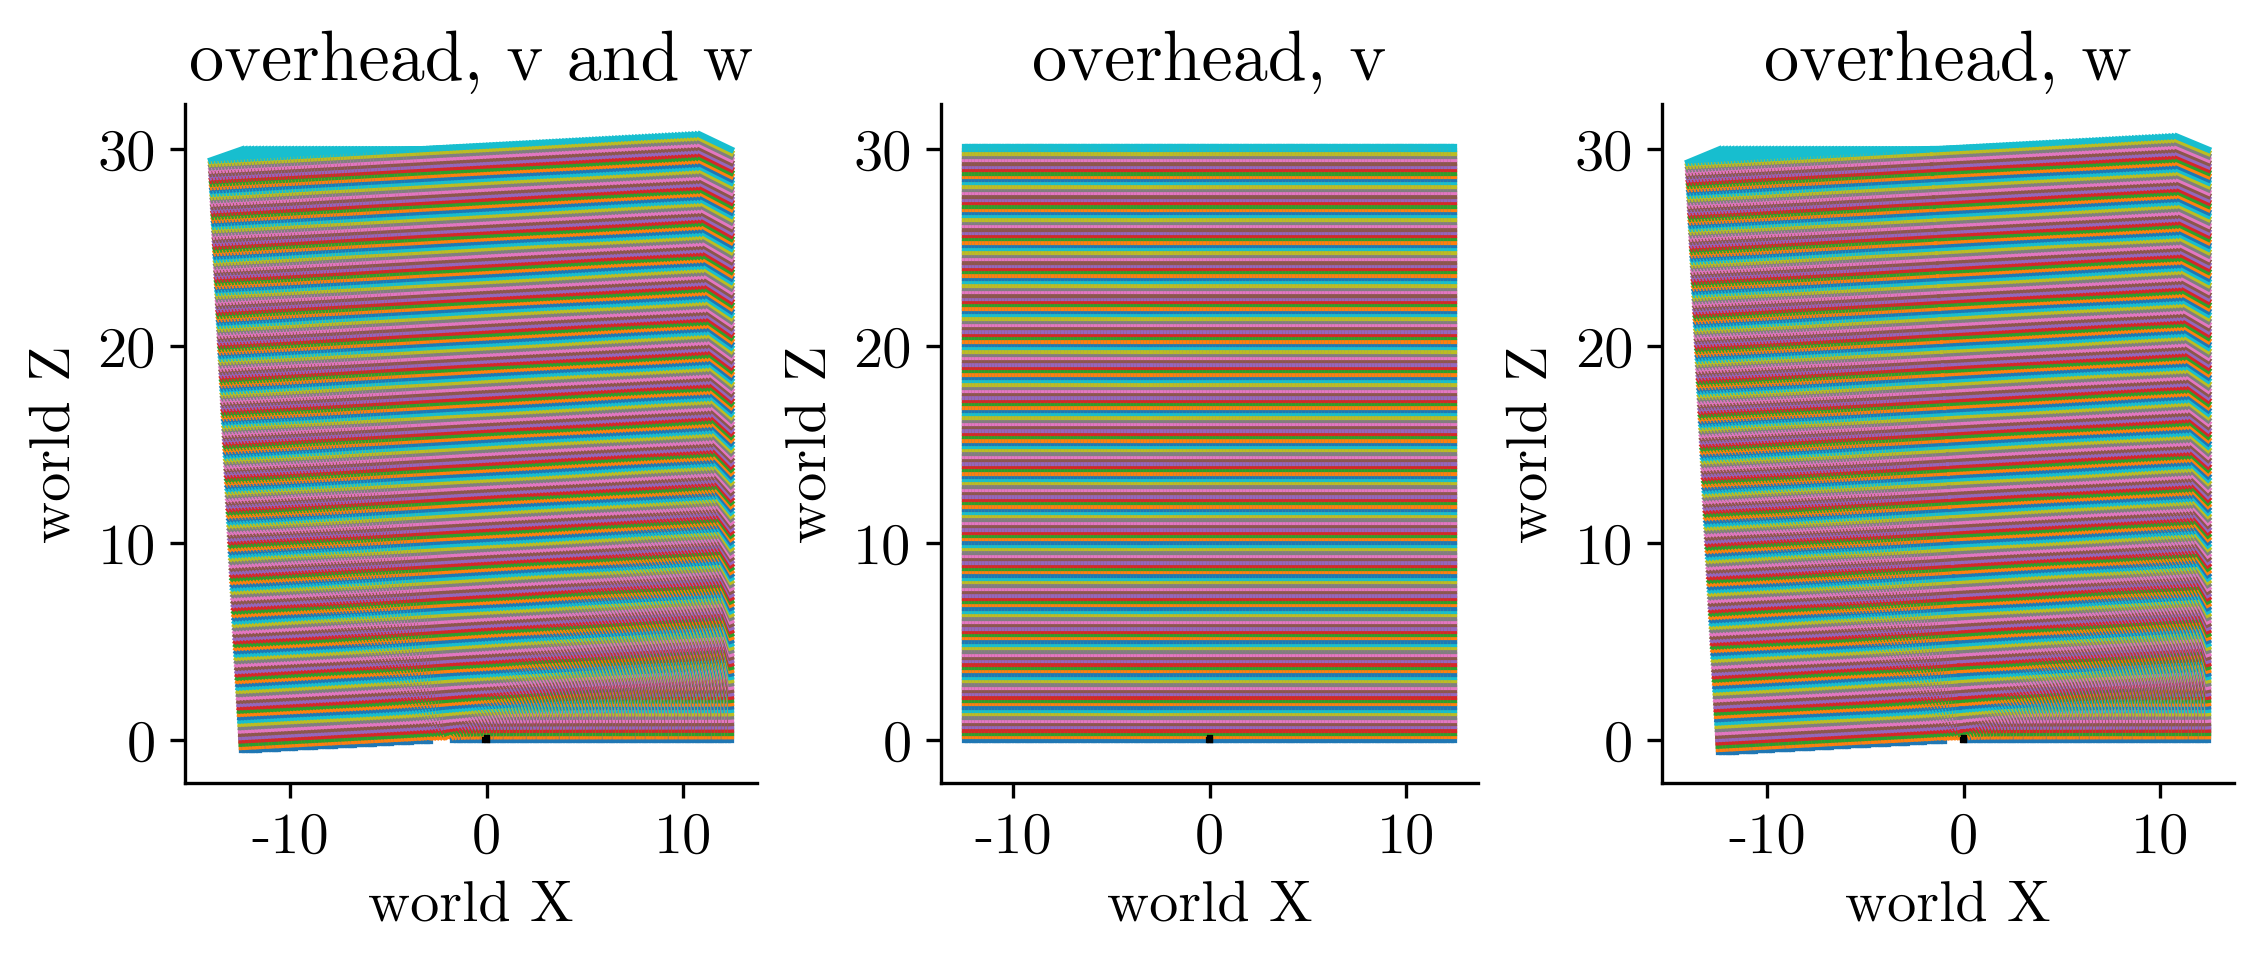

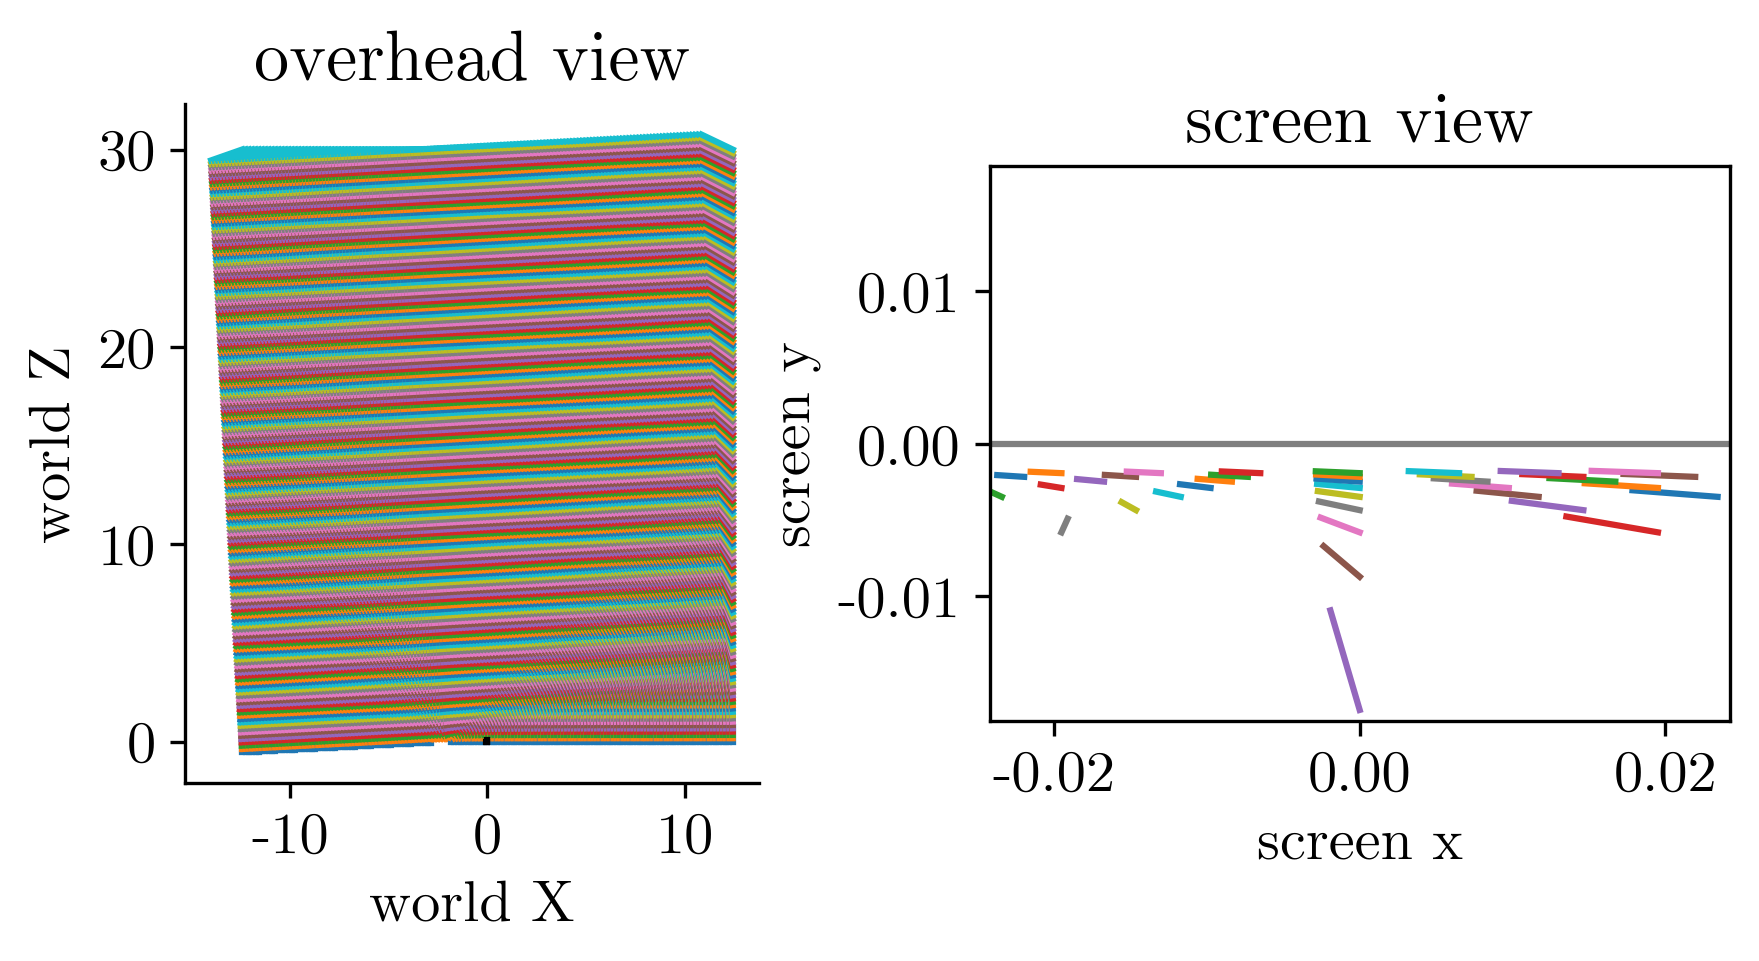

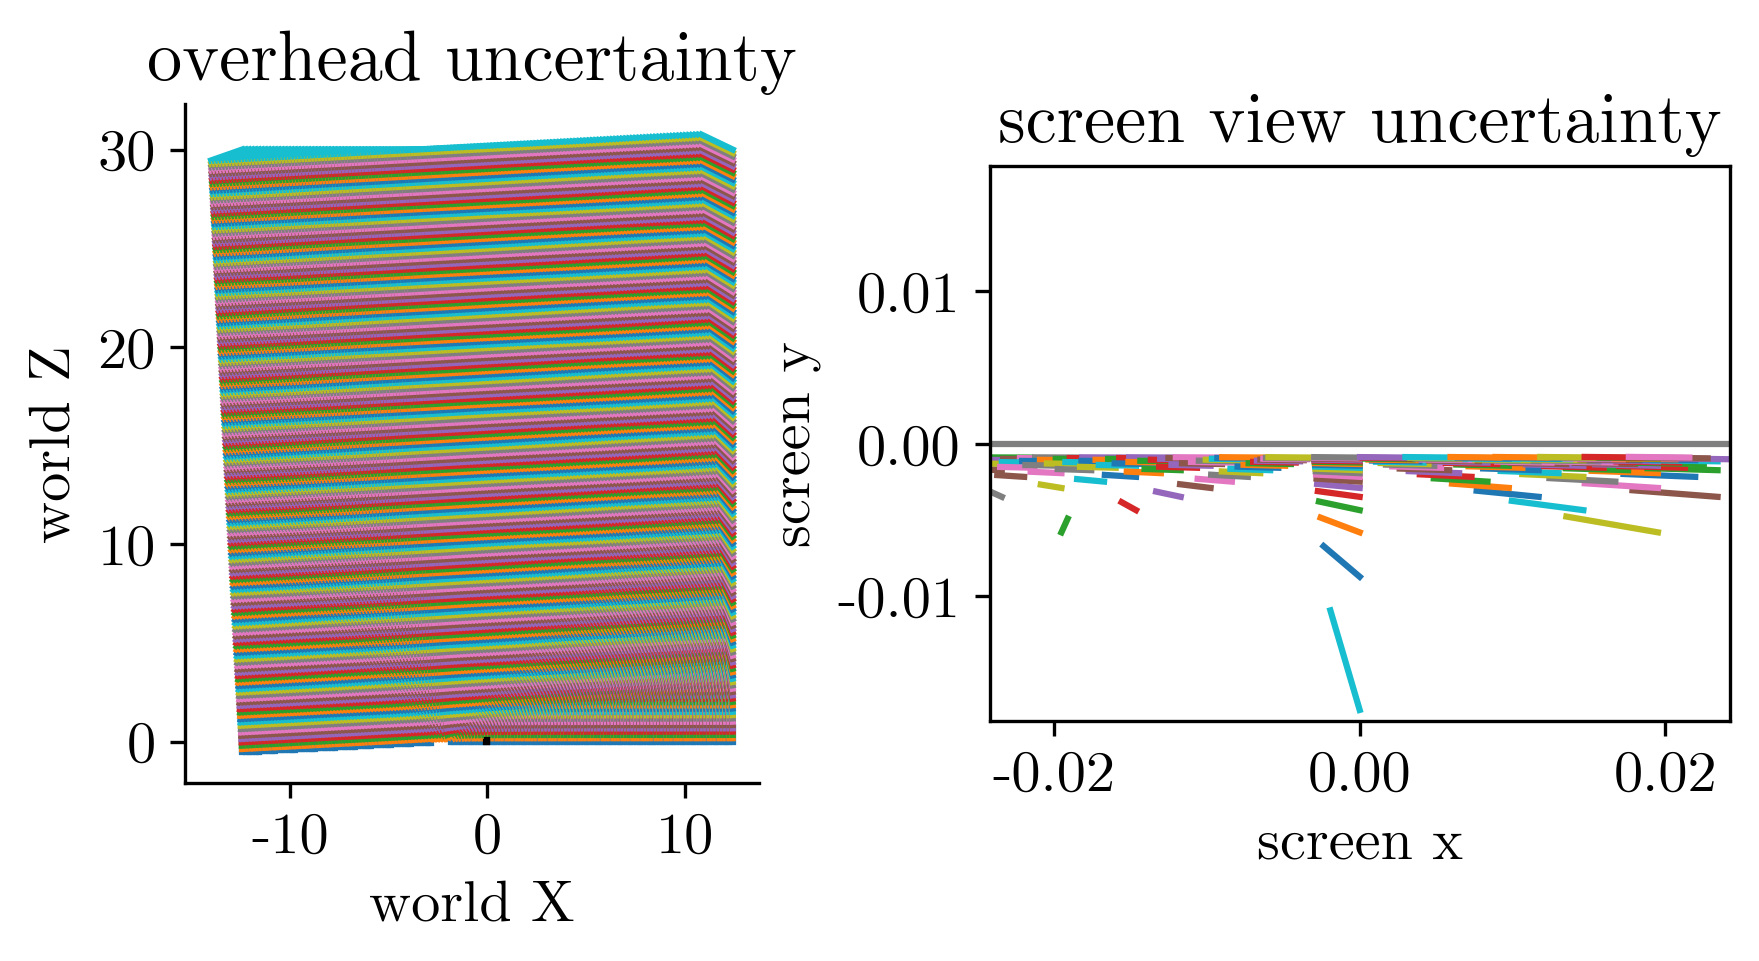

jacobian on I (regardless of size), the information for Tv and Tw are: 
 0.012197362798068245 0.05753973749707849


In [7]:
with initiate_plot(7,3,300) as f:
    ax=f.add_subplot(131)
    ax.scatter(dot3d[0],dot3d[2], s=1)
    quickspine(ax)
    ax.set_xlabel('world X')
    ax.set_ylabel('world Z')
    ax.set_title('overhead')
    ax=f.add_subplot(132)
    ax.scatter(dot2d[0],dot2d[1], s=1)
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xlim(-screenx,screenx)
    ax.set_ylim(-screeny,screeny)
    # quickspine(ax)
    ax.set_xlabel('screen x')
    ax.set_ylabel('screen y')
    ax.set_title('screen view')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot([-1,1],[0,0],'k')
    ax.set_aspect('equal', adjustable='box')

    ax=f.add_subplot(133)
    ax.scatter(recovered3d[0],recovered3d[2], s=1)
    quickspine(ax)
    ax.set_xlabel('world X')
    ax.set_ylabel('world Z')
    ax.set_title('in fov dots overhead')
    ax.set_aspect('equal', adjustable='box')
    for a,b in zip(fov_world[1:], fov_world[:-1]):
        sx,_,sz=a
        ex,_,ez=b
        ax.plot([sx,ex],[sz,ez],'k')
    plt.tight_layout()

# plot the motion field
with initiate_plot(9,3,300) as f:
    ax=f.add_subplot(131)
    for i in range(ndots):
        sx,sy,sz=dot3d.T[i]
        ex,ey,ez=dot3d.T[i]+T.T[i]
        ax.plot([sx,ex], [sz,ez])
    quickspine(ax)
    ax.set_xlabel('world X')
    ax.set_ylabel('world Z')
    ax.plot([0,0],[0,v], 'k')
    ax.plot([0,-w],[0,0],'k')
    ax.set_title('overhead, v and w')
    ax.set_aspect('equal', adjustable='box')

    ax=f.add_subplot(132,sharey=ax)
    for i in range(ndots):
        sx,sy,sz=dot3d.T[i]
        ex,ey,ez=dot3d.T[i]+vs.T[i]
        ax.plot([sx,ex], [sz,ez])
    quickspine(ax)
    ax.set_xlabel('world X')
    ax.set_ylabel('world Z')
    ax.plot([0,0],[0,v], 'k')
    ax.plot([0,-w],[0,0],'k')
    ax.set_title('overhead, v')
    ax.set_aspect('equal', adjustable='box')
    
    ax=f.add_subplot(133,sharey=ax)
    for i in range(ndots):
        sx,sy,sz=dot3d.T[i]
        ex,ey,ez=dot3d.T[i]+ws.T[i]
        ax.plot([sx,ex], [sz,ez])
    quickspine(ax)
    ax.set_xlabel('world X')
    ax.set_ylabel('world Z')
    ax.plot([0,0],[0,v], 'k')
    ax.plot([0,-w],[0,0],'k')
    ax.set_title('overhead, w')
    ax.set_aspect('equal', adjustable='box')

# traslate on to 2d image
with initiate_plot(7,3,300) as f:
    ax=f.add_subplot(121)
    for i in range(ndots):
        sx,sy,sz=dot3d.T[i]
        ex,ey,ez=dot3d.T[i]+T.T[i]
        ax.plot([sx,ex], [sz,ez])
    quickspine(ax)
    ax.set_xlabel('world X')
    ax.set_ylabel('world Z')
    ax.plot([0,0],[0,v], 'k')
    ax.plot([0,-w],[0,0],'k')
    ax.set_title('overhead view')
    ax.plot()
    ax.set_aspect('equal', adjustable='box')

    ax=f.add_subplot(122)
    for i in range(ndots):
        sx,sy=dot2d.T[i]
        if -screenx<sx<screenx and -screeny<sy<-screeny*0.1:
            ex,ey=dot2dend.T[i]
            ax.plot([sx,ex], [sy,ey])
    ax.set_xlim(-screenx,screenx)
    ax.set_ylim(-screeny,screeny)
    # quickspine(ax)
    ax.set_xlabel('screen x')
    ax.set_ylabel('screen y')
    ax.set_title('screen view')
    ax.plot([-1,1],[0,0])
    ax.set_aspect('equal', adjustable='box')



with initiate_plot(7,3,300) as f:
    ax=f.add_subplot(121)
    for i in range(ndots):
        sx,sy,sz=dot3d.T[i]
        ex,ey,ez=dot3d.T[i]+T.T[i]
        ax.plot([sx,ex], [sz,ez])
    # ax.axis('equal')
    quickspine(ax)
    ax.set_xlabel('world X')
    ax.set_ylabel('world Z')
    ax.plot([0,0],[0,v], 'k')
    ax.plot([0,-w],[0,0],'k')
    ax.set_title('overhead uncertainty')
    ax.set_aspect('equal', adjustable='box')

    ax=f.add_subplot(122)
    for i in range(ndots):
        x,y=dot2d.T[i]
        if -screenx<x<screenx and -screeny<y<-screeny*0.05:
            sx,sy=dot2d.T[i]
            ex,ey=dot2dend.T[i]
            ax.plot([sx,ex], [sy,ey])
    # ax.axis('equal')
    ax.set_xlim(-screenx,screenx)
    ax.set_ylim(-screeny,screeny)
    # quickspine(ax)
    ax.set_xlabel('screen x')
    ax.set_ylabel('screen y')
    ax.set_title('screen view uncertainty')
    ax.plot([-1,1],[0,0])
    ax.set_aspect('equal', adjustable='box')

recoverTuncertainty=[]
for i in range(ndots):
    p=dot2d.T[i]
    x,y=p
    if -screenx<x<screenx and -screeny<y<-screeny*0.1:
        J=jocob(p)
        sigma2=J@np.eye(2)@J.T
        recoverTuncertainty.append(sigma2)
infoTv=[1/mat[0,0] for mat in recoverTuncertainty]
infoTw=[1/mat[1,1] for mat in recoverTuncertainty]
print('jacobian on I (regardless of size), the information for Tv and Tw are: \n', sum(infoTv), sum(infoTw))



In [129]:
# calculate information
dt=0.1
c=-0.1 # the ground level
zmax=5
fov=pi/2
sensorsize=0.024197724949859098
fc=sensorsize/np.tan(fov/2)
fov_v=np.arctan(np.tan(pi/4)*16/9)
screenx=np.tan(fov/2)*fc
screeny=screenx

samplereso=53
vwreso=7
allv=np.linspace(1e-2,2,vwreso)
allw=np.linspace(0.01,pi/2,vwreso)
resv=np.zeros(shape=(vwreso,vwreso))
resw=np.zeros(shape=(vwreso,vwreso))
vwcovs=[]
for j,v in enumerate(allv):
    for k,w in enumerate(allw):

        dot3d, dot2d, T3d, T2d, vs, ws=get_dots(v*dt, w*dt, samplereso=22, fov=fov, zmax=zmax, fc=fc, ndots=100,userandom=False)
        # print( len(dot3d.T), len(dot2d.T), len(T3d.T), len(T2d.T), len(vs.T), len(ws.T) )
        fisher=[]
        fovdots=[]
        screen_covs=[]
        ndots=len(dot3d.T)
        for i in range(ndots):
            p=dot2d.T[i]
            P=dot3d.T[i]
            M=T3d.T[i]
            m=T2d.T[i]
            x,y=p
            if -screenx<x<screenx and -screeny<y<-screeny*0.2:
                J=jocobworld2screen(P,M)
                screenuncertainty=obs_uncertainty(p,m)
                # try:
                #     sigma2=J.T@np.linalg.inv(screenuncertainty)@J
                sigma2=J.T@np.linalg.pinv(screenuncertainty)@J
                fisher.append(sigma2)
                screen_covs.append(screenuncertainty)
                fovdots.append(i)
                if sigma2[0,0]<0: break
                # except np.linalg.LinAlgError:
                #     pass
            
        infoTv=[mat[0,0] for mat in fisher]
        infoTw=[mat[1,1] for mat in fisher]
        screenuncertaintyxx=[mat[0,0] for mat in screen_covs]
        screenuncertaintyyy=[mat[1,1] for mat in screen_covs]
        # print('jacobian on cov(vx, vy), the information for Tv and Tw are: \n', sum(infoTv), sum(infoTw))
        resv[j,k]=sum(infoTv)
        resw[j,k]=sum(infoTw)

        norminfov= (np.array(infoTv) - np.min(infoTv))/ (np.max(infoTv) - np.min(infoTv)) /10
        norminfow= (np.array(infoTw) - np.min(infoTw)) / (np.max(infoTw) - np.min(infoTw)) /10
        print(np.sum(np.array(fisher), axis=0))
        vwcovs.append(np.linalg.pinv(np.sum(np.array(fisher), axis=0)))
        
        # step=1
        # with initiate_plot(7,3,300) as f:
        #     ax=f.add_subplot(121)
        #     for jj in range(0,len(fovdots),step):
        #         ii=fovdots[jj]
        #         sx,sy,sz=dot3d.T[ii]
        #         ex,ey,ez=dot3d.T[ii]+(vs.T[ii]/np.linalg.norm(vs.T[ii]))*norminfov[jj]
        #         ax.plot([sx,ex], [sz,ez],color='k',alpha=0.5)    
        #     quickspine(ax)
        #     ax.set_xlabel('world X')
        #     ax.set_ylabel('world Z')
        #     # ax.plot([0,0],[0,v], 'k')
        #     # ax.plot([0,-w],[0,0],'k')
        #     ax.set_title('overhead, info V={}'.format(v))

        #     ax=f.add_subplot(122)
        #     for jj in range(0,len(fovdots),step):
        #         ii=fovdots[jj]
        #         sx,sy,sz=dot3d.T[ii]
        #         ex,ey,ez=dot3d.T[ii]+(ws.T[ii]/np.linalg.norm(ws.T[ii]))*norminfow[jj]
        #         ax.plot([sx,ex], [sz,ez],color='k',alpha=0.5)  
        #     quickspine(ax)
        #     ax.set_xlabel('world X')
        #     ax.set_ylabel('world Z')
        #     # ax.plot([0,0],[0,v], 'k')
        #     # ax.plot([0,-w],[0,0],'k')
        #     ax.set_title('overhead, info W={}'.format(w))

        # with initiate_plot(7,3,300) as f:
        #     ax=f.add_subplot(121)
        #     for jj in range(0,len(fovdots),step):
        #         ii=fovdots[jj]
        #         sx,sy=dot2d.T[ii]
        #         ax.errorbar(sx,sy, xerr=screenuncertaintyxx[jj]*0.1, yerr=screenuncertaintyyy[jj]*0.001,color='k',alpha=0.3)    
        #     quickspine(ax)
        #     ax.set_xlabel('screen x')
        #     ax.set_ylabel('screen y')
        #     ax.set_xlim(-screenx, screenx)
        #     ax.set_ylim(-screeny, screeny)
        #     # ax.plot([0,0],[0,v], 'k')
        #     # ax.plot([0,-w],[0,0],'k')
        #     ax.set_title('overhead, v={},w={}'.format(v,w))

notify(msg='ready')


[[73.45905033  1.93892109]
 [ 1.93892109  0.76629093]]
[[4.28902016e+03 5.18855627e+01]
 [5.18855627e+01 1.74369474e+00]]
[[1178.96371848   -1.84686624]
 [  -1.84686624    1.18712513]]
[[ 2.17872919e+03 -1.95596844e+01]
 [-1.95596844e+01  8.93222356e-01]]
[[ 3.32913271e+03 -2.76522039e+01]
 [-2.76522039e+01  6.78454113e-01]]
[[ 4.28583199e+03 -3.03651937e+01]
 [-3.03651937e+01  5.18278849e-01]]
[[ 5.01326954e+03 -3.04040952e+01]
 [-3.04040952e+01  4.01252282e-01]]
[[0.35602271 0.03542164]
 [0.03542164 0.01463416]]
[[0.32633648 0.03575922]
 [0.03575922 0.01280378]]
[[0.31026251 0.04510981]
 [0.04510981 0.03067712]]
[[46.70899691 -2.44119409]
 [-2.44119409  0.27688616]]
[[ 6.95111297e+03 -3.71613766e+01]
 [-3.71613766e+01  5.98512554e-01]]
[[381.22060426   3.96745044]
 [  3.96745044   0.63398854]]
[[522.03014022   6.89734117]
 [  6.89734117   0.54299401]]
[[0.11932336 0.01187191]
 [0.01187191 0.0049386 ]]
[[0.11318686 0.01189872]
 [0.01189872 0.00470897]]
[[0.10904042 0.01163089]
 [0.011

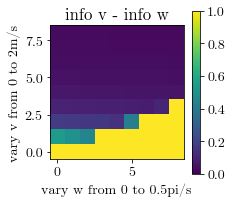

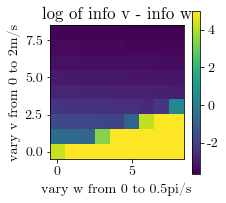

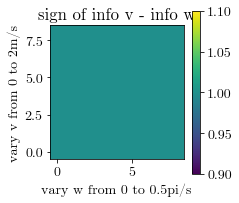

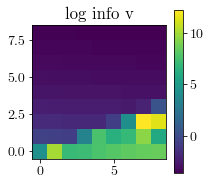

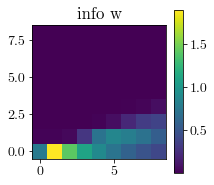

In [119]:
# information plots

signmat=np.sign(resv-resw)

plt.title('info v - info w')
plt.xlabel('vary w from 0 to 0.5pi/s')
plt.ylabel('vary v from 0 to 2m/s')
plt.imshow(((resv-resw))[:], origin='lower left', vmin=0,vmax=1);plt.colorbar();plt.show()

plt.title('log of info v - info w')
plt.xlabel('vary w from 0 to 0.5pi/s')
plt.ylabel('vary v from 0 to 2m/s')
plt.imshow(np.log((resv-resw))[:], origin='lower left',vmax=5);plt.colorbar();plt.show()

plt.title('sign of info v - info w')
plt.xlabel('vary w from 0 to 0.5pi/s')
plt.ylabel('vary v from 0 to 2m/s')
plt.imshow(signmat, origin='lower left');plt.colorbar();plt.show()

plt.title('log info v')
plt.imshow(np.log(resv), origin='lower left');plt.colorbar();plt.show()

plt.title('info w')
plt.imshow(resw, origin='lower left');plt.colorbar();plt.show()

# print(resv-resw)

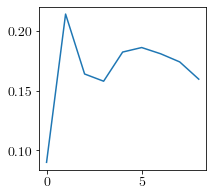

In [120]:
np.mean(resv[7:],axis=0),
plt.plot(np.mean(resw[:],axis=0))


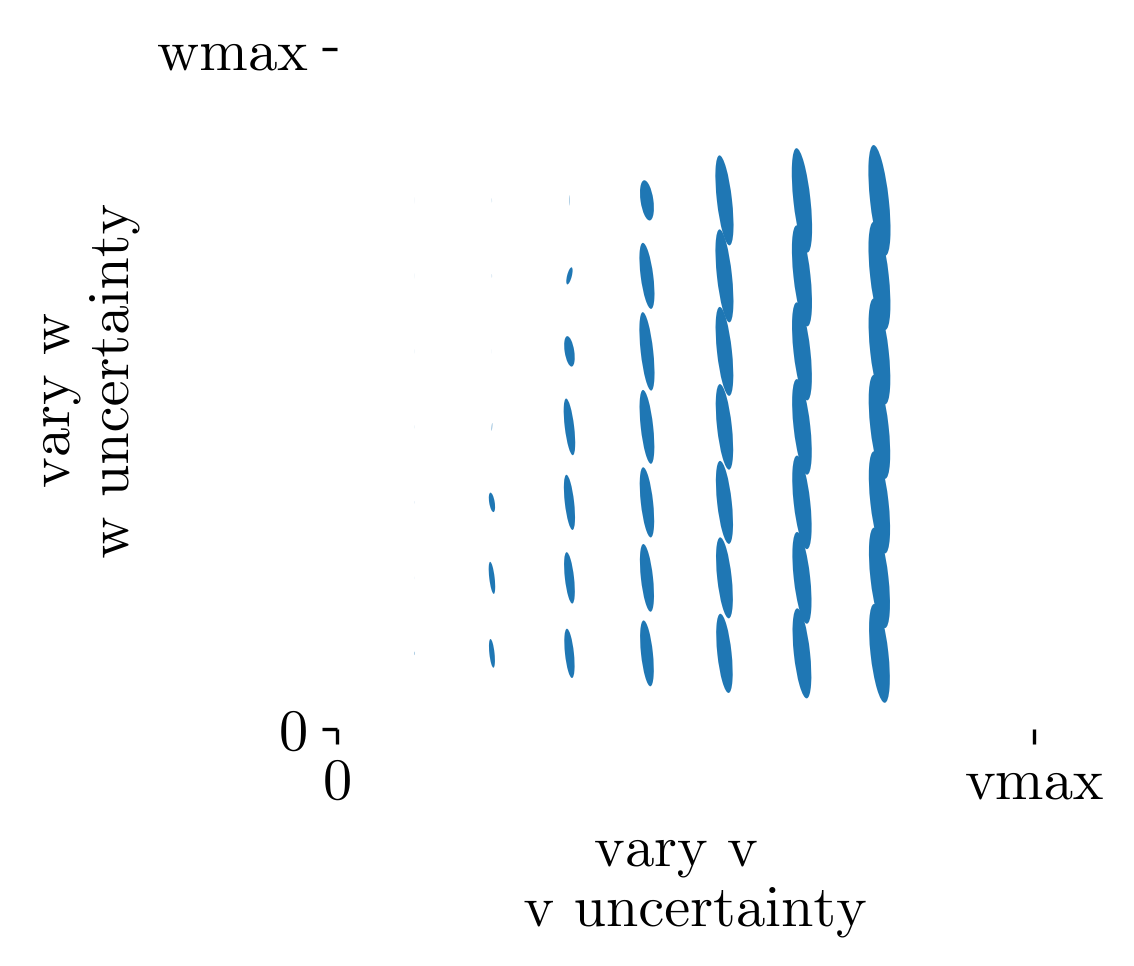

In [132]:
# uncertainty ellipse plots
from plot_ult import *
vstart=0
everyn=1
with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    for j,v in enumerate(allv): 
        for k,w in enumerate(allw):
            if k%everyn==0 and j%everyn==0:
                ind=j*(len(allw)//everyn)+k
                cov=vwcovs[ind]
                # print(cov[0,0]*cov[1,1]-cov[0,1]**2)
                # print(j,k)
                cov=cov*0.0001
                plot_cov_ellipse(cov,[j,k],ax=ax, alpha=1) # w in x and v in y
    ax.set_ylim(-1,8)
    ax.set_xlim(-1,8)
    ax.set_yticks(ax.get_xlim())
    ax.set_xticks(ax.get_ylim())
    ax.set_yticklabels([0, 'wmax'])
    ax.set_xticklabels([0, 'vmax'])
    quickallspine(ax)
    ax.set_ylabel('vary w \n w uncertainty')
    ax.set_xlabel('vary v \n v uncertainty')
    # quicksave('vary vw uncertainty ellipse')

In [400]:
print(allv[2],np.sum(resv, axis=0))
print(allw[4],np.sum(resw, axis=1))
(resv-resw)[10,20]


0.134375 [9.13627614e+01 4.72580033e+02 3.77458439e+04 4.06518123e+02
 7.22521402e+03 2.06551828e+03 1.16172407e+03 7.47182120e+02
 5.52838442e+03 7.92171397e+02 2.86697442e+03 2.85034731e+03
 4.21557837e+03 1.24326744e+03 2.75866366e+03 1.04417104e+04
 1.60437199e+05 5.35730405e+03 3.16439418e+03 1.02977022e+06
 2.29679657e+04 8.61858864e+03 1.04857325e+04 1.81604608e+04
 1.27249560e+04 5.92628673e+03 3.35542678e+03 5.31318709e+03
 2.71328979e+05 2.00614358e+05 5.32921515e+04 6.23544328e+04
 7.33854011e+05]
0.20509954084936208 [ 51.36180258  52.73229784  54.12401035  55.53694059  56.97108899
  58.42645592  59.90304171  61.40084666  62.91987105  64.46011513
  66.0215791   67.60426319  69.20816757  70.83329242  72.47963788
  74.14720411  75.83599123  77.54599937  79.27722864  81.02967915
  82.80335099  84.59824426  86.41435903  88.25169539  90.11025341
  91.99003316  93.8910347   95.8132581   97.75670341  99.72137068
 101.70725996 103.71437131 105.74270476]


2.4602237466397137

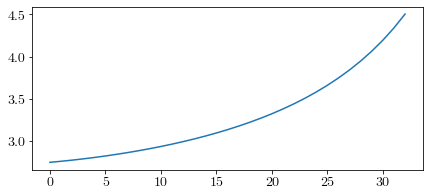

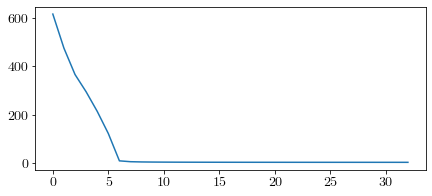

In [395]:
plt.plot(np.median(resv, axis=0));plt.show()
plt.plot(np.median(resv, axis=1));plt.show()

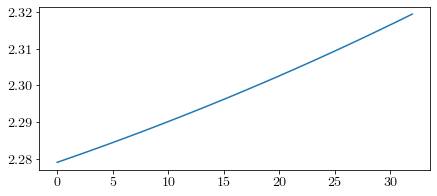

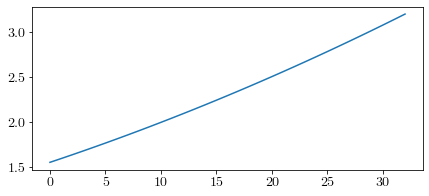

In [396]:
plt.plot(np.median(resw, axis=0));plt.show()
plt.plot(np.median(resw, axis=1));plt.show()